# Import

In [1]:
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
region = 11
mother_directory = f"/content/drive/MyDrive/MS thesis/[optimize] Training, Testing/RG{region}/"
# raw_rg1_clustered = pd.read_csv("/content/drive/MyDrive/MS thesis/preliminary site selection/CALABARZON/calabarzon_clusters.csv")
raw_rg1_clustered = pd.read_csv(mother_directory + "PCF_data.csv")
# use pcf data nalang para you dont get nans for sure?

neighbors_df = pd.read_csv(mother_directory + 'neighbours.csv')
candidate_sites = pd.read_csv(mother_directory + "candidate_sites.csv")
candidate_sites

# raw_rg1_clustered = raw_rg1_clustered.drop(columns=['Unnamed: 0'])
neighbors_df.rename(columns={'fid': 'ID'}, inplace=True)
# raw_rg1_clustered = raw_rg1_clustered.drop(columns=['HCFAI.1'])
raw_rg1_clustered.columns

Index(['flood_probability_value', 'rain intensity_value', 'drought_value',
       'Distance_to_Nearest_RHU_km', 'popden_chi', 'popden_eld', 'popden_all',
       'popden_wom', 'popden_w_1', 'popden_you', 'HCFAI', 'total_population',
       'RHU_Presence', 'ID', 'buildability_landcov', 'Road_Presence',
       'POI_Presence', 'Nearest_RHU', 'Cluster'],
      dtype='object')

In [3]:
def HCI_calc(total_ai, total_gi, total_hi, total_ji, total_ki, total_mi, distance, road_bi, POI_ci, landCov_di, hazard1_ei, hazard2_ei, hazard3_ei, rhus_fi):
    total_vulnerable = total_gi + total_hi + total_ji + total_ki + total_mi
    total_pop = total_ai
    population_to_be_served = total_vulnerable + np.maximum(0, total_pop - total_vulnerable)
    y = np.where(population_to_be_served == 0, 0, 20000 / ((population_to_be_served) * (distance + rhus_fi)))
    mc = np.tanh(y)
    w_bi = 0.3  # roads
    w_ci = 0.2  # POIs
    w_di = 0.5  # land cov
    b = (POI_ci * w_ci) + (road_bi * w_bi) + (landCov_di * w_di)
    rain_intensity_normalized = (hazard1_ei - hazard1_ei.min()) / (hazard1_ei.max() - hazard1_ei.min())
    flood_probability_normalized = (hazard2_ei - hazard2_ei.min()) / (hazard2_ei.max() - hazard2_ei.min())
    drought_mean_normalized = (hazard3_ei - hazard3_ei.min()) / (hazard3_ei.max() - hazard3_ei.min())
    w_rain = 0.4
    w_flood = 0.3
    w_drought = 0.3
    c = (w_rain * rain_intensity_normalized) + (w_flood * flood_probability_normalized) + (w_drought * drought_mean_normalized)
    f = b - c
    f = np.tanh(f)
    hci = mc * f
    hcfai = (1 + np.tanh(hci / 2)) / 2  # Sigmoid function

    return hcfai

def overallHCFAI(region_df):
    if 'HCFAI' in region_df.columns:
        HCFAI_overall = region_df['HCFAI'].sum()
    elif 'new HCFAI' in region_df.columns:
        HCFAI_overall = region_df['new HCFAI'].sum()
    return HCFAI_overall

def selectTopSites(candidate_sites, region_df, selected_sites, n):
    if len(selected_sites) < n:  # if optimal and existing RHUs list is incomplete
        while len(selected_sites) < n:
            new_site = candidate_sites.iloc[:1].copy()
            selected_sites = pd.concat([selected_sites, new_site], ignore_index=True)
            candidate_sites = candidate_sites.drop(candidate_sites.index[0]).reset_index(drop=True)

    region_df = region_df.drop('total_population', axis=1)

    columns_to_merge = ['ID',
                        'popden_chi', 'popden_eld', 'popden_wom', 'popden_you', 'popden_w_1',
                        'popden_all', 'flood_probability_value', 'rain intensity_value',
                        'drought_value', 'buildability_landcov', 'RHU_Presence',
                        'Road_Presence', 'POI_Presence', 'Nearest_RHU',
                        'Distance_to_Nearest_RHU_km']

    merged_sites = candidate_sites.merge(region_df[columns_to_merge], on='ID', how='left')
    merged_sites['HCFAI'] = HCI_calc(merged_sites['popden_all'],
                                     merged_sites['popden_chi'],
                                     merged_sites['popden_eld'],
                                     merged_sites['popden_wom'],
                                     merged_sites['popden_you'],
                                     merged_sites['popden_w_1'],
                                     merged_sites['Distance_to_Nearest_RHU_km'],
                                     merged_sites['Road_Presence'],
                                     merged_sites['POI_Presence'],
                                     merged_sites['buildability_landcov'],
                                     merged_sites['rain intensity_value'],
                                     merged_sites['flood_probability_value'],
                                     merged_sites['drought_value'],
                                     merged_sites['RHU_Presence'],
                                     )

    missing_cols = [col for col in region_df.columns if col != 'ID']
    for col in missing_cols:
        if 'ID' not in region_df.columns:
            region_df.set_index('ID', inplace=True)
        merged_sites[col] = merged_sites[col].fillna(region_df[col])

    top_sites = merged_sites.sort_values(by='HCFAI', ascending=False).head(n)
    return top_sites

def removeAdjacentSites(region_df, candidate_sites, selected_sites, neighbors_df, n):
    idx_with_RHU = region_df[region_df['RHU_Presence'] == 1]
    adjacent_sites = set()
    with_RHU_indices = selected_sites['ID'].tolist()
    for site_id in selected_sites['ID']:
        if site_id in neighbors_df['ID'].values:
            neighbors = neighbors_df.loc[neighbors_df['ID'] == site_id, 'neighbours'].iloc[0]
            adjacent_sites.update(neighbors.split(','))
    adjacent_sites.update(idx_with_RHU['ID'])
    adjacent_sites.update(selected_sites['ID'])
    adjacent_sites = [int(site) for site in adjacent_sites]
    candidate_sites = candidate_sites[~candidate_sites['ID'].isin(adjacent_sites)].reset_index(drop=True)

    print(f"{len(candidate_sites)} Candidate sites left")
    print(f"This is what we'll put on QGIS: {selected_sites['ID'].tolist()}")

    if len(candidate_sites) > n:
      for i in with_RHU_indices:
          print(f"Site {i} has the following sites to choose from: {candidate_sites['ID'].tolist()}")
          if i in adjacent_sites:
              print(f"Site {i} was highkey sus for not saying they have neighbors ...")
              with_RHU_indices.remove(i)
              selected_sites = selected_sites.drop(selected_sites[selected_sites['ID'] == i].index).reset_index(drop=True)
    elif len(candidate_sites) <= n:
      return candidate_sites, selected_sites, idx_with_RHU

    selected_sites['HCFAI'] = HCI_calc(selected_sites['popden_all'], selected_sites['popden_chi'],
                                       selected_sites['popden_eld'], selected_sites['popden_wom'],
                                       selected_sites['popden_you'], selected_sites['popden_w_1'],
                                       selected_sites['Distance_to_Nearest_RHU_km'],
                                       selected_sites['Road_Presence'], selected_sites['POI_Presence'],
                                       selected_sites['buildability_landcov'], selected_sites['rain intensity_value'],
                                       selected_sites['flood_probability_value'], selected_sites['drought_value'],
                                       selected_sites['RHU_Presence'])
    return candidate_sites, selected_sites, idx_with_RHU

def optimize(region_df, candidate_sites, neighbors_df, num_facilities):
    original_HCFAI = overallHCFAI(region_df)
    print("Original HCFAI:", original_HCFAI)
    selected_sites = pd.DataFrame(columns=region_df.columns)
    top_sites = selectTopSites(candidate_sites, region_df, selected_sites, num_facilities - len(selected_sites))

    while len(selected_sites) < num_facilities:
        # candidate_sites, top_sites, idx_with_RHU = removeAdjacentSites(region_df, candidate_sites, top_sites, neighbors_df, num_facilities)
        if len(candidate_sites) <= num_facilities:
          top_sites = candidate_sites
        elif len(candidate_sites) > num_facilities:
          top_sites = selectTopSites(candidate_sites, region_df, selected_sites, num_facilities - len(selected_sites))
          selected_sites = top_sites

        candidate_sites, top_sites, idx_with_RHU = removeAdjacentSites(region_df, candidate_sites, top_sites, neighbors_df, num_facilities)
        selected_sites = pd.concat([selected_sites, top_sites]).reset_index(drop=True)
        remaining_sites = region_df[~region_df['ID'].isin(selected_sites['ID'])]
        remaining_HCFAI = overallHCFAI(remaining_sites)
        selected_sites_HCFAI = overallHCFAI(selected_sites)
        updated_HCFAI = remaining_HCFAI + selected_sites_HCFAI
        print("Updated HCFAI:", updated_HCFAI)
        print(f"{len(selected_sites)} selected sites")

        if len(selected_sites) == num_facilities:
            print("Accept!!!!!!!!!!!!!!")
            return selected_sites, idx_with_RHU, original_HCFAI, updated_HCFAI

        elif len(candidate_sites) <= num_facilities:
            return selected_sites, idx_with_RHU, original_HCFAI, updated_HCFAI

        else:
            print("Reject!!!!!!!!!!!!!!")
            print("Selected sites:", len(selected_sites))
            top_sites = selectTopSites(candidate_sites, region_df, selected_sites, num_facilities - len(selected_sites))

    return selected_sites, idx_with_RHU, original_HCFAI, updated_HCFAI

# trained rg1 model

In [ ]:
print(f"Candidate sites: {len(candidate_sites)}")
# Optimize selection of health facility sites
PCF = 481
selected_facilities, hex_with_RHU, og_HCFAI, updated_HCFAI = optimize(raw_rg1_clustered, candidate_sites, neighbors_df, PCF)
print(selected_facilities.to_string(index=False))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
selected_facilities = list(selected_facilities['ID'])
hex_with_RHU = list(hex_with_RHU['ID'])
hex_with_RHU
print(f"Optimal sites: {len(selected_facilities)}")
print(f"Sites with RHUs: {len(hex_with_RHU)}")

Optimal sites: 962
Sites with RHUs: 19


In [ ]:
os = selected_facilities
cs = list(candidate_sites['ID'])
es = hex_with_RHU

# hex_with_RHU = list(hex_with_RHU['ID'])
print(f"{len(cs)} candidate sites")
print(f"{cs}")
print(f"{len(set(os))} optimal sites")
print(f"{list(set(os))}")
print(f"{es}")

3538 candidate sites
[3268092, 3268095, 3268109, 3268110, 3268111, 3268115, 3269491, 3269492, 3270856, 3270873, 3272238, 3272239, 3272240, 3272242, 3272245, 3272251, 3272252, 3272254, 3272255, 3273620, 3273627, 3273629, 3273630, 3273632, 3273633, 3273634, 3273637, 3273639, 3273643, 3275005, 3275006, 3275010, 3275011, 3275012, 3275013, 3275018, 3275019, 3275025, 3276383, 3276384, 3276385, 3276393, 3276394, 3276395, 3276396, 3276402, 3276403, 3276408, 3276419, 3276421, 3277762, 3277771, 3277775, 3277776, 3277777, 3277784, 3277789, 3277803, 3279145, 3279150, 3279153, 3279154, 3279156, 3279157, 3279158, 3279159, 3279172, 3279180, 3279184, 3279186, 3280526, 3280530, 3280531, 3280532, 3280533, 3280534, 3280535, 3280536, 3280537, 3280538, 3280539, 3280540, 3280541, 3280542, 3280543, 3280544, 3280546, 3280547, 3280553, 3280562, 3280568, 3281907, 3281908, 3281912, 3281913, 3281914, 3281915, 3281917, 3281918, 3281919, 3281920, 3281921, 3281922, 3281923, 3281924, 3281925, 3281926, 3281927, 328192

# trained rg11 model

In [4]:
print(f"Candidate sites: {len(candidate_sites)}")
# Optimize selection of health facility sites
PCF = 328
selected_facilities, hex_with_RHU, og_HCFAI, updated_HCFAI = optimize(raw_rg1_clustered, candidate_sites, neighbors_df, PCF)
print(selected_facilities.to_string(index=False))


selected_facilities = list(selected_facilities['ID'])
hex_with_RHU = list(hex_with_RHU['ID'])
hex_with_RHU
print(f"Optimal sites: {len(selected_facilities)}")
print(f"Sites with RHUs: {len(hex_with_RHU)}")

os = selected_facilities
cs = list(candidate_sites['ID'])
es = hex_with_RHU

# hex_with_RHU = list(hex_with_RHU['ID'])
print(f"{len(cs)} candidate sites")
print(f"{cs}")
print(f"{len(set(os))} optimal sites")
print(f"{list(set(os))}")
print(f"{es}")

Candidate sites: 6768
Original HCFAI: 2720.5026501014436
6083 Candidate sites left
This is what we'll put on QGIS: [3404946, 3389733, 3432519, 3298512, 3384173, 3439512, 3440894, 3440889, 3403565, 3404947, 3396663, 3396661, 3411858, 3398049, 3433986, 3284661, 3391122, 3410501, 3341348, 3299887, 3388362, 3464383, 3438130, 3395228, 3457463, 3406326, 3399416, 3422903, 3371730, 3410473, 3382821, 3440893, 3323400, 3322018, 3446424, 3464370, 3464380, 3440890, 3464382, 3316488, 3388319, 3382793, 3414618, 3396658, 3396659, 3463004, 3439515, 3433984, 3324777, 3403526, 3292962, 3294344, 3294343, 3417389, 3399330, 3399423, 3380052, 3421490, 3410500, 3416027, 3416001, 3396660, 3428441, 3429823, 3409079, 3297112, 3400723, 3425668, 3440892, 3309583, 3422906, 3424289, 3413238, 3385578, 3331686, 3348240, 3399429, 3440796, 3438133, 3413242, 3382814, 3407720, 3385575, 3385573, 3406342, 3404959, 3406339, 3396643, 3396641, 3398025, 3438119, 3435355, 3400773, 3338592, 3435370, 3324767, 3436748, 3407722, 34

# Validation

In [ ]:
import random
import pandas as pd

def getRandom48(candidate_sites, random_seed=None):
    """
    Randomly select 48 sites from the candidate sites DataFrame.

    Parameters:
        candidate_sites (DataFrame): DataFrame containing information about all candidate sites.
        random_seed (int): Random seed for reproducibility.

    Returns:
        DataFrame: Randomly selected 48 sites DataFrame.
    """
    if random_seed is not None:
        random.seed(random_seed)
    candidate_sites_shuffled = candidate_sites.sample(frac=1).reset_index(drop=True)
    random_48 = candidate_sites_shuffled.sample(n=PCF)
    return random_48


def randomize(region_df, candidate_sites, random_seed):
    """
    Randomize the selection of 48 sites and update the overall HCFAI value.
    Parameters:
        region_df (DataFrame): DataFrame containing information about all sites in the region.
    Returns:
        tuple: Tuple containing the updated overall HCFAI value and the IDs of randomly selected sites.
    """
    HCFAI_overall_before = overallHCFAI(region_df)
    # print("Overall HCFAI (before randomization): ", HCFAI_overall_before)
    random_48 = getRandom48(candidate_sites, random_seed)
    columns_to_merge = ['ID',
                        'popden_chi', 'popden_eld', 'popden_wom', 'popden_you', 'popden_w_1',
                        'popden_all', 'flood_probability_value', 'rain intensity_value',
                        'drought_value', 'buildability_landcov', 'RHU_Presence',
                        'Road_Presence', 'POI_Presence', 'Nearest_RHU',
                        'Distance_to_Nearest_RHU_km', 'HCFAI', 'total_population']
    merged_sites = random_48.merge(region_df[columns_to_merge], on='ID', how='left')
    missing_cols = [col for col in region_df.columns if col != ['ID']]
    for col in missing_cols:
        if 'ID' not in region_df.columns:
            region_df.set_index('ID', inplace=True)
        merged_sites[col] = merged_sites[col].fillna(region_df[col])
    # Calculate HCFAI for the remaining sites in region_df
    remaining_sites = region_df[~region_df['ID'].isin(merged_sites['ID'])]
    remaining_HCFAI = overallHCFAI(remaining_sites)
    print(remaining_HCFAI)
    selected_sites_HCFAI = overallHCFAI(merged_sites)
    print(selected_sites_HCFAI)

    # Calculate updated overall HCFAI
    updated_HCFAI = remaining_HCFAI + selected_sites_HCFAI
    # print(f"Updated HCFAI: ", updated_HCFAI)
    return updated_HCFAI, random_48['ID'].tolist()

# Example usage
rdm_hcfai = []
rdm_points = []
for i in range(10):
    random_seed = i  # Use a different random seed for each iteration
    rdm_ovHCFAI, rdm_48 = randomize(raw_rg1_clustered, candidate_sites, random_seed)
    rdm_hcfai.append(rdm_ovHCFAI)
    rdm_points.append(rdm_48)

rdm_HCFAI_avg = sum(rdm_hcfai) / len(rdm_hcfai)
highest_rdm_HCFAI = max(rdm_hcfai)
# print("Average HCFAI after randomization: ", rdm_HCFAI_avg)

Results_rdmsum = pd.DataFrame({
    'Hex IDs': rdm_points,
    'HCFAI': rdm_hcfai
})

print("=========== OG HCFAI RESULTS ===========")
print("ORIGINAL HCFAI", og_HCFAI)
print("=========== RANDOM HCFAI RESULTS ===========")
# print("RANDOMIZED HCFAI [All, 10-fold]", rdm_hcfai)
print("RANDOMIZED HCFAI [10-fold]: ", highest_rdm_HCFAI)
# print("RANDOMIZED HCFAI AVG[10 fold]: ", rdm_HCFAI_avg)
print("=========== OPTIMIZED HCFAI RESULTS ===========")
print("OPTIMIZED HCFAI ", updated_HCFAI)

2483.6211739942423
236.88147610720148
2481.7888525276803
238.71379757376332
2485.7974370548213
234.7052130466226
2483.9873457465183
236.51530435492577
2484.2855482895825
236.21710181186123
2482.6015793671304
237.90107073431307
2485.1734383478943
235.32921175355014
2483.501438177962
237.00121192348166
2485.6456748287987
234.8569752726454
2482.548150982798
237.9544991186463
=========== OG HCFAI RESULTS ===========
ORIGINAL HCFAI 2720.5026501014436
=========== RANDOM HCFAI RESULTS ===========
RANDOMIZED HCFAI [10-fold]:  2720.5026501014445
=========== OPTIMIZED HCFAI RESULTS ===========
OPTIMIZED HCFAI  2949.6233393273146


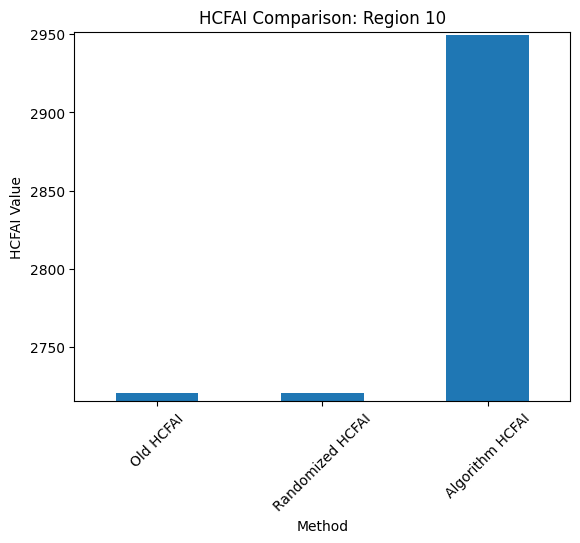

In [ ]:
hcfai_compare_df =  pd.DataFrame(
    {' ': ['SUM'],
    'Old HCFAI': og_HCFAI,
     'Randomized HCFAI': highest_rdm_HCFAI,
     'Algorithm HCFAI': updated_HCFAI
    })

import matplotlib.pyplot as plt
# Preparing the data for plotting
# Since we have only one row with label 'SUM', we'll use it as index
hcfai_compare_df.set_index(' ', inplace=True)
hcfai_compare_df = hcfai_compare_df.transpose()  # Transpose for easier plotting

# Plotting the bar chart
hcfai_compare_df.plot(kind='bar', legend=False)
plt.title(f'HCFAI Comparison: Region {region-1}')
plt.ylabel('HCFAI Value')
plt.ylim(min([og_HCFAI, highest_rdm_HCFAI, updated_HCFAI])-5, max([og_HCFAI, highest_rdm_HCFAI, updated_HCFAI])+2)
plt.xlabel('Method')
plt.xticks(rotation=45)
plt.show()

# Validation - trained rg11 model

2590.5404760205756
129.96217408086812
2591.032877129246
129.46977297219792
2589.799206532803
130.70344356864084
2594.0470385953563
126.45561150608748
2592.6360221229547
127.86662797848905
2592.8271469864203
127.67550311502336
2588.8096811494534
131.69296895199068
2593.207720299411
127.29492980203312
2591.437206266621
129.0654438348226
2594.788697763907
125.71395233753701
=========== OG HCFAI RESULTS ===========
ORIGINAL HCFAI 2720.5026501014436
=========== RANDOM HCFAI RESULTS ===========
RANDOMIZED HCFAI [10-fold]:  2720.502650101444
=========== OPTIMIZED HCFAI RESULTS ===========
OPTIMIZED HCFAI  2799.2683477999008


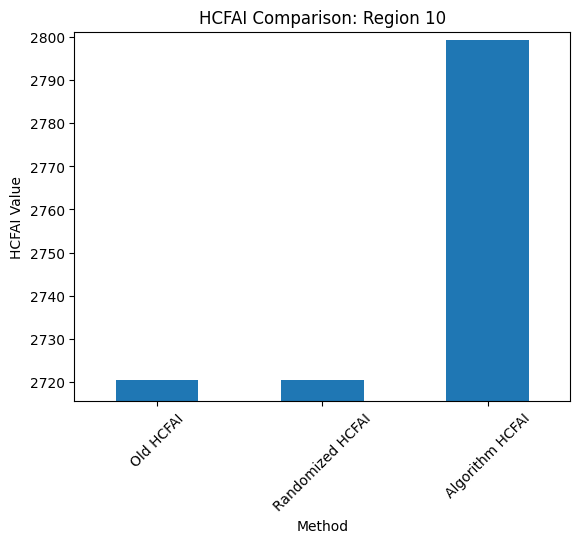

In [5]:
import random
import pandas as pd

def getRandom48(candidate_sites, random_seed=None):
    """
    Randomly select 48 sites from the candidate sites DataFrame.

    Parameters:
        candidate_sites (DataFrame): DataFrame containing information about all candidate sites.
        random_seed (int): Random seed for reproducibility.

    Returns:
        DataFrame: Randomly selected 48 sites DataFrame.
    """
    if random_seed is not None:
        random.seed(random_seed)
    candidate_sites_shuffled = candidate_sites.sample(frac=1).reset_index(drop=True)
    random_48 = candidate_sites_shuffled.sample(n=PCF)
    return random_48

def randomize(region_df, candidate_sites, random_seed):
    """
    Randomize the selection of 48 sites and update the overall HCFAI value.
    Parameters:
        region_df (DataFrame): DataFrame containing information about all sites in the region.
    Returns:
        tuple: Tuple containing the updated overall HCFAI value and the IDs of randomly selected sites.
    """
    HCFAI_overall_before = overallHCFAI(region_df)
    # print("Overall HCFAI (before randomization): ", HCFAI_overall_before)
    random_48 = getRandom48(candidate_sites, random_seed)
    columns_to_merge = ['ID',
                        'popden_chi', 'popden_eld', 'popden_wom', 'popden_you', 'popden_w_1',
                        'popden_all', 'flood_probability_value', 'rain intensity_value',
                        'drought_value', 'buildability_landcov', 'RHU_Presence',
                        'Road_Presence', 'POI_Presence', 'Nearest_RHU',
                        'Distance_to_Nearest_RHU_km', 'HCFAI', 'total_population']
    merged_sites = random_48.merge(region_df[columns_to_merge], on='ID', how='left')
    missing_cols = [col for col in region_df.columns if col != ['ID']]
    for col in missing_cols:
        if 'ID' not in region_df.columns:
            region_df.set_index('ID', inplace=True)
        merged_sites[col] = merged_sites[col].fillna(region_df[col])
    # Calculate HCFAI for the remaining sites in region_df
    remaining_sites = region_df[~region_df['ID'].isin(merged_sites['ID'])]
    remaining_HCFAI = overallHCFAI(remaining_sites)
    print(remaining_HCFAI)
    selected_sites_HCFAI = overallHCFAI(merged_sites)
    print(selected_sites_HCFAI)

    # Calculate updated overall HCFAI
    updated_HCFAI = remaining_HCFAI + selected_sites_HCFAI
    # print(f"Updated HCFAI: ", updated_HCFAI)
    return updated_HCFAI, random_48['ID'].tolist()

# Example usage
rdm_hcfai = []
rdm_points = []
for i in range(10):
    random_seed = i  # Use a different random seed for each iteration
    rdm_ovHCFAI, rdm_48 = randomize(raw_rg1_clustered, candidate_sites, random_seed)
    rdm_hcfai.append(rdm_ovHCFAI)
    rdm_points.append(rdm_48)

rdm_HCFAI_avg = sum(rdm_hcfai) / len(rdm_hcfai)
highest_rdm_HCFAI = max(rdm_hcfai)
# print("Average HCFAI after randomization: ", rdm_HCFAI_avg)

Results_rdmsum = pd.DataFrame({
    'Hex IDs': rdm_points,
    'HCFAI': rdm_hcfai
})

print("=========== OG HCFAI RESULTS ===========")
print("ORIGINAL HCFAI", og_HCFAI)
print("=========== RANDOM HCFAI RESULTS ===========")
# print("RANDOMIZED HCFAI [All, 10-fold]", rdm_hcfai)
print("RANDOMIZED HCFAI [10-fold]: ", highest_rdm_HCFAI)
# print("RANDOMIZED HCFAI AVG[10 fold]: ", rdm_HCFAI_avg)
print("=========== OPTIMIZED HCFAI RESULTS ===========")
print("OPTIMIZED HCFAI ", updated_HCFAI)

hcfai_compare_df =  pd.DataFrame(
    {' ': ['SUM'],
    'Old HCFAI': og_HCFAI,
     'Randomized HCFAI': highest_rdm_HCFAI,
     'Algorithm HCFAI': updated_HCFAI
    })

import matplotlib.pyplot as plt
# Preparing the data for plotting
# Since we have only one row with label 'SUM', we'll use it as index
hcfai_compare_df.set_index(' ', inplace=True)
hcfai_compare_df = hcfai_compare_df.transpose()  # Transpose for easier plotting

# Plotting the bar chart
hcfai_compare_df.plot(kind='bar', legend=False)
plt.title(f'HCFAI Comparison: Region {region-1}')
plt.ylabel('HCFAI Value')
plt.ylim(min([og_HCFAI, highest_rdm_HCFAI, updated_HCFAI])-5, max([og_HCFAI, highest_rdm_HCFAI, updated_HCFAI])+2)
plt.xlabel('Method')
plt.xticks(rotation=45)
plt.show()